# Twitter-POS Dataset

Tweet part-of-speech tagging is a natural language processing dataset focusing on tagging words. The dataset is relatively small (1000 training, 327 validation, and 500 testing tweets), which make it suitable for us to study the generalization ability of the trained model.

In this notebook, we test 6 different activation functions, i.e., 'relu', 'prelu', 'elu', 'silu', 'mish', and 'gelu'.

# Initialization

Import packages and mount drive.

In [71]:
import numpy as np
import pickle
import sys
import io
import os

In [72]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Implement helper functions for Tweet-POS dataset. (heavily based on this [repo](https://github.com/hendrycks/GELUs/blob/master/twitter_pos.py))

In [73]:
#
# Begin Twitter Helper Functions
#

def embeddings_to_dict(filename):
    '''
    :param filename: the file name of the word embeddings | file is assumed
    to follow this format: "word[tab]dimension 1[space]dimension 2[space]...[space]dimension 50"
    :return: a dictionary with keys that are words and values that are the embedding of a word
    '''
    with io.open(filename, 'r', encoding='utf-8') as f:
        word_vecs = {}
        for line in f:
            line = line.strip('\n').split()
            word_vecs[line[0]] = np.array([float(s) for s in line[1:]])

    return word_vecs


def data_to_mat(filename, vocab, tag_to_number, window_size=1, start_symbol=u'UUUNKKK',
                one_hot=False, return_labels=True):
    '''
    :param filename: the filename of a training, development, devtest, or test set
    :param vocab: a list of strings, one for each embedding (the keys of a dictionary)
    :param tag_to_number: a dictionary of tags to predict and a numerical encoding of those tags;
    with this, we will predict numbers instead of strings
    :param window_size: the context window size for the left and right; thus we have 2*window_size + 1
    words considered at a time
    :param start_symbol: since the <s> symbol has no embedding given, chose a symbol in the vocab
    to replace <s>. Common choices are u'UUUNKKK' or u'</s>'
    :return: a n x (window_size*2 + 1) matrix containing context windows and the center word
    represented as strings; n is the number of examples. ALSO return a n x |tag_to_number|
    matrix of labels for the n examples with a one-hot (1-of-k) encoding
    '''
    with io.open(filename, 'r', encoding='utf-8') as f:
        x, tweet_words, y = [], [], []
        start = True
        for line in f:
            line = line.strip('\n')

            if len(line) == 0:              # if end of tweet
                tweet_words.extend([u'</s>'] * window_size)

                # ensure tweet words are in vocab; if not, map to "UUUNKKK"

                tweet_words = [w if w in vocab else u'UUUNKKK' for w in tweet_words]

                # from this tweet, add the training tasks to dataset
                # the tags were already added to y
                for i in range(window_size, len(tweet_words) - window_size):
                    x.append(tweet_words[i-window_size:i+window_size+1])

                tweet_words = []
                start = True
                continue

            # if before end
            word, label = line.split('\t')

            if start:
                tweet_words.extend([start_symbol] * window_size)
                start = False

            tweet_words.append(word)

            if return_labels is True:
                if one_hot is True:
                    label_one_hot = len(tag_to_number) * [0]
                    label_one_hot[tag_to_number[label]] += 1

                    y.append(label_one_hot)
                else:
                    y.append(tag_to_number[label])

    return np.array(x), np.array(y)


def word_list_to_embedding(words, embeddings, embedding_dimension=50):
    '''
    :param words: an n x (2*window_size + 1) matrix from data_to_mat
    :param embeddings: an embedding dictionary where keys are strings and values
    are embeddings; the output from embeddings_to_dict
    :param embedding_dimension: the dimension of the values in embeddings; in this
    assignment, embedding_dimension=50
    :return: an n x ((2*window_size + 1)*embedding_dimension) matrix where each entry of the
    words matrix is replaced with its embedding
    '''
    m, n = words.shape
    words = words.reshape((-1))

    return np.array([embeddings[w] for w in words], dtype=np.float32).reshape(m, n*embedding_dimension)


def get_act_fn(nonlinearity_name):
    if nonlinearity_name == 'relu':
        return torch.nn.ReLU()
    elif nonlinearity_name == 'prelu':
        return torch.nn.PReLU()
    elif nonlinearity_name == 'elu':
        return torch.nn.ELU()
    elif nonlinearity_name == 'silu':
        return torch.nn.SiLU()
    elif nonlinearity_name == 'mish':
        return torch.nn.Mish()
    elif nonlinearity_name == 'gelu':
        return torch.nn.GELU()
    else:
        raise NameError("Need 'relu', 'prelu', 'elu', 'silu', 'mish', 'gelu' for nonlinearity_name")


#
# End Twitter Helper Functions
#

Generate input data.

In [74]:
window_size = 1

# note that we encode the tags with numbers for later convenience
tag_to_number = {
    u'N': 0, u'O': 1, u'S': 2, u'^': 3, u'Z': 4, u'L': 5, u'M': 6,
    u'V': 7, u'A': 8, u'R': 9, u'!': 10, u'D': 11, u'P': 12, u'&': 13, u'T': 14,
    u'X': 15, u'Y': 16, u'#': 17, u'@': 18, u'~': 19, u'U': 20, u'E': 21, u'$': 22,
    u',': 23, u'G': 24
}

embeddings = embeddings_to_dict('/content/gdrive/My Drive/GELUs-master/data/Tweets/embeddings-twitter.txt')
vocab = embeddings.keys()

# we replace <s> with </s> since it has no embedding, and </s> is a better embedding than UNK
xt, yt = data_to_mat('/content/gdrive/My Drive/GELUs-master/data/Tweets/tweets-train.txt', vocab, tag_to_number, window_size=window_size,
                     start_symbol=u'</s>')
xdev, ydev = data_to_mat('/content/gdrive/My Drive/GELUs-master/data/Tweets/tweets-dev.txt', vocab, tag_to_number, window_size=window_size,
                         start_symbol=u'</s>')
xdtest, ydtest = data_to_mat('/content/gdrive/My Drive/GELUs-master/data/Tweets/tweets-devtest.txt', vocab, tag_to_number, window_size=window_size,
                             start_symbol=u'</s>')

data = {
    'x_train': xt, 'y_train': yt,
    'x_dev': xdev, 'y_dev': ydev,
    'x_test': xdtest, 'y_test': ydtest
}

In [75]:
print('x_train', data['x_train'], '\n')

print('y_train', data['y_train'], '\n')

x_train [['</s>' 'i' 'predict']
 ['i' 'predict' 'i']
 ['predict' 'i' "won't"]
 ...
 [',' 'my' 'followers']
 ['my' 'followers' 'xd']
 ['followers' 'xd' '</s>']] 

y_train [ 1  7  1 ... 11  0 21] 



# Network Training

Set up training hyperparameters.

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset


num_epochs = 50
num_tags = 25
hidden_size = 256
batch_size = 16
embedding_dimension = 50
example_size = (2 * window_size + 1) * embedding_dimension
num_examples = data['y_train'].shape[0]
num_batches = num_examples // batch_size
save_every = num_batches // 5 # save training information 5 times per epoch


nonlinearity_list = ['relu', 'prelu', 'elu', 'silu', 'mish', 'gelu']

Initialize the network. 

According to the paper, we use a simple two-layer network in order to test the generalization ability and convergence speed under different activation functions.

In [77]:
class Net(nn.Module):
    def __init__(self, act_fn):
        super().__init__()
        self.fc1 = nn.Linear(example_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_tags)
        self.dropout = nn.Dropout(0.2)
        self.act_fn = act_fn
        
        # initialization
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = self.act_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.act_fn(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Train the network by the following settings:
- Number of Epoch: `50`
- Optimizer: `Adam`
- Loss: `CrossEntropyLoss`
- Learning rate: `[1e-3, 1e-4, 1e-5]`

In [78]:
learning_rate = 1e-2 # 1e-3 # 1e-4 # 1e-5


for nonlinearity_name in nonlinearity_list:
    
    for n_exp in range(3):


        print('>> %s #%d' % (nonlinearity_name, n_exp))

        history = {
                "lr": learning_rate,
                'train_loss': [], 'val_loss': [], 'test_loss': [],
                'train_acc': [], 'val_acc': [], 'test_acc': []
            }
          
        act_fn = get_act_fn(nonlinearity_name)
        net = Net(act_fn)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
              
        for epoch in range(num_epochs):
            
            print('>>>> Epoch', epoch + 1)            

            # shuffle data every epoch
            indices = np.arange(num_examples)
            np.random.shuffle(indices)
            data['x_train'] = data['x_train'][indices]
            data['y_train'] = data['y_train'][indices]  

            # reset loss            
            running_loss = 0.0
  
            # train
            net.train()

            for i in range(num_batches):
                offset = i * batch_size
                inputs = word_list_to_embedding(data['x_train'][offset:offset + batch_size, :],
                                            embeddings, embedding_dimension)
                labels = data['y_train'][offset:offset + batch_size] 

                inputs = torch.tensor(inputs)
                labels = torch.tensor(labels)
            
                # training
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss

            # training loss
            train_loss = running_loss / len(data['y_train'])
            print('>>>>>> [train_loss] \t %.4f' % train_loss)


            # validation
            net.eval()

            with torch.no_grad():
              inputs = word_list_to_embedding(data['x_train'], embeddings, embedding_dimension)
              labels = data['y_train']

              inputs = torch.tensor(inputs)
              labels = torch.tensor(labels)

              outputs = net(inputs)
              
              # compute loss
              train_loss = criterion(outputs, labels)

              # compute accuracy
              predictions = torch.argmax(outputs, dim=1)
              train_acc = (predictions == labels).float().sum() / len(outputs)

              # print statistics
              print('>>>>>> [train_loss] \t %.4f' % train_loss)
              print('>>>>>> [train_acc] \t %.4f' % train_acc)
              history["train_loss"].append(train_loss)
              history["train_acc"].append(train_acc)

            with torch.no_grad():
              inputs = word_list_to_embedding(data['x_dev'], embeddings, embedding_dimension)
              labels = data['y_dev']

              inputs = torch.tensor(inputs)
              labels = torch.tensor(labels)

              outputs = net(inputs)
              
              # compute loss
              val_loss = criterion(outputs, labels)

              # compute accuracy
              predictions = torch.argmax(outputs, dim=1)
              val_acc = (predictions == labels).float().sum() / len(outputs)

              # print statistics
              print('>>>>>> [val_loss] \t %.4f' % val_loss)
              print('>>>>>> [val_acc] \t %.4f' % val_acc)
              history["val_loss"].append(val_loss)
              history["val_acc"].append(val_acc)

            # testing
            with torch.no_grad():
              inputs = word_list_to_embedding(data['x_test'], embeddings, embedding_dimension)
              labels = data['y_test']

              inputs = torch.tensor(inputs)
              labels = torch.tensor(labels)

              outputs = net(inputs)
              
              # compute loss
              test_loss = criterion(outputs, labels)

              # compute accuracy
              predictions = torch.argmax(outputs, dim=1)
              test_acc = (predictions == labels).float().sum() / len(outputs)

              # print statistics
              print('>>>>>> [test_loss] \t %.4f' % test_loss)
              print('>>>>>> [test_acc] \t %.4f' % test_acc)
              history["test_loss"].append(test_loss)
              history["test_acc"].append(test_acc)

              
        pickle.dump(history, open("/content/gdrive/MyDrive/DL-HW1/twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p", "wb"))

串流輸出內容已截斷至最後 5000 行。
>>>>>> [val_loss] 	 1.8532
>>>>>> [val_acc] 	 0.8383
>>>>>> [test_loss] 	 1.3440
>>>>>> [test_acc] 	 0.8318
>>>> Epoch 28
>>>>>> [train_loss] 	 0.0562
>>>>>> [train_loss] 	 0.6741
>>>>>> [train_acc] 	 0.8472
>>>>>> [val_loss] 	 2.0216
>>>>>> [val_acc] 	 0.7937
>>>>>> [test_loss] 	 1.6413
>>>>>> [test_acc] 	 0.7978
>>>> Epoch 29
>>>>>> [train_loss] 	 0.0484
>>>>>> [train_loss] 	 0.6510
>>>>>> [train_acc] 	 0.8487
>>>>>> [val_loss] 	 2.7808
>>>>>> [val_acc] 	 0.7887
>>>>>> [test_loss] 	 2.1613
>>>>>> [test_acc] 	 0.7866
>>>> Epoch 30
>>>>>> [train_loss] 	 0.0396
>>>>>> [train_loss] 	 0.3361
>>>>>> [train_acc] 	 0.9037
>>>>>> [val_loss] 	 2.4220
>>>>>> [val_acc] 	 0.8381
>>>>>> [test_loss] 	 1.3951
>>>>>> [test_acc] 	 0.8379
>>>> Epoch 31
>>>>>> [train_loss] 	 0.0379
>>>>>> [train_loss] 	 0.3510
>>>>>> [train_acc] 	 0.9050
>>>>>> [val_loss] 	 2.1198
>>>>>> [val_acc] 	 0.8534
>>>>>> [test_loss] 	 1.6411
>>>>>> [test_acc] 	 0.8413
>>>> Epoch 32
>>>>>> [train_loss] 	 0.0

# Discussion

To help us observe the convergence, we show the loss value and classification error based on the median of three runs.

They follow the settings of:
- Learning rate = [1e-2, 1e-3, 1e-4, 1e-5]

In [178]:
import matplotlib.pyplot as plt
import numpy as np

num_exp = 3
accuracy = {'lr1e-2': {}, 'lr1e-3': {}, 'lr1e-4': {}, 'lr1e-5':{}}

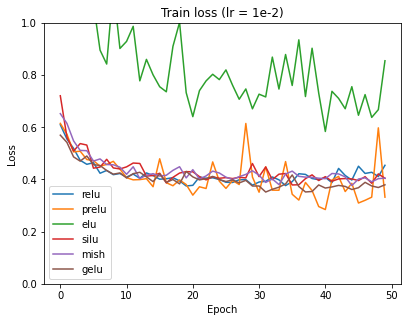

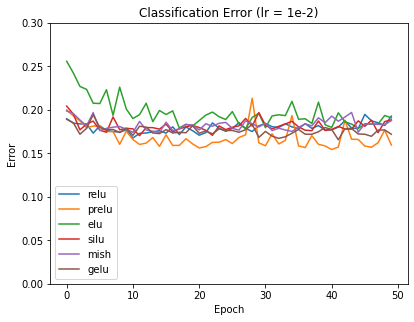

[Classification error (best)]
relu 	 16.765%
prelu 	 15.436%
elu 	 17.827%
silu 	 17.030%
mish 	 17.394%
gelu 	 16.555%


In [179]:
root = '/content/gdrive/MyDrive/DL-HW1/lr1e-2/'

save_history = {}

for nonlinearity_name in nonlinearity_list:

  mean_history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
          'train_acc': [], 'val_acc': [], 'test_acc': []
        }

  for n_exp in range(num_exp):
    with open(os.path.join(root, "twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p"), "rb") as f:
      cur_history = pickle.load(f)
      for k in mean_history.keys():
        mean_history[k].append(cur_history[k])

  for k in mean_history.keys():
    mean_history[k] = np.median(mean_history[k], axis=0)

  save_history[nonlinearity_name] = mean_history

for nonlinearity_name in nonlinearity_list:
  plt.plot(save_history[nonlinearity_name]['train_loss'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.title("Train loss (lr = 1e-2)")
plt.legend()
plt.show()
plt.close()

for nonlinearity_name in nonlinearity_list:
  plt.plot(1-save_history[nonlinearity_name]['test_acc'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0.0, 0.3)
plt.title("Classification Error (lr = 1e-2)")
plt.legend()
plt.show()
plt.close()


print('[Classification error (best)]')
for nonlinearity_name in nonlinearity_list:
  print('%s \t %.3f%%' % (nonlinearity_name, np.min(1-save_history[nonlinearity_name]['test_acc']) * 100))
  accuracy['lr1e-2'][nonlinearity_name] = (1 - np.min(1-save_history[nonlinearity_name]['test_acc'])) * 100

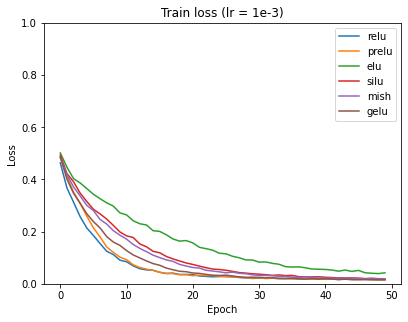

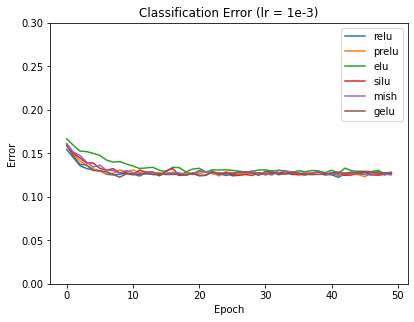

[Classification error (best)]
relu 	 12.248%
prelu 	 12.304%
elu 	 12.570%
silu 	 12.416%
mish 	 12.472%
gelu 	 12.248%


In [180]:
root = '/content/gdrive/MyDrive/DL-HW1/lr1e-3/'

save_history = {}

for nonlinearity_name in nonlinearity_list:

  mean_history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
          'train_acc': [], 'val_acc': [], 'test_acc': []
        }

  for n_exp in range(num_exp):
    with open(os.path.join(root, "twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p"), "rb") as f:
      cur_history = pickle.load(f)
      for k in mean_history.keys():
        mean_history[k].append(cur_history[k])

  for k in mean_history.keys():
    mean_history[k] = np.median(mean_history[k], axis=0)

  save_history[nonlinearity_name] = mean_history

for nonlinearity_name in nonlinearity_list:
  plt.plot(save_history[nonlinearity_name]['train_loss'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.title("Train loss (lr = 1e-3)")
plt.legend()
plt.show()
plt.close()

for nonlinearity_name in nonlinearity_list:
  plt.plot(1-save_history[nonlinearity_name]['test_acc'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0.0, 0.3)
plt.title("Classification Error (lr = 1e-3)")
plt.legend()
plt.show()
plt.close()


print('[Classification error (best)]')
for nonlinearity_name in nonlinearity_list:
  print('%s \t %.3f%%' % (nonlinearity_name, np.min(1-save_history[nonlinearity_name]['test_acc']) * 100))
  accuracy['lr1e-3'][nonlinearity_name] = (1 - np.min(1-save_history[nonlinearity_name]['test_acc'])) * 100

In the setting `lr=1e-3`, Elu shows the slowest convergence speed among all the others according to the first figure.


Due to the high learning rate, all methods converage relatively fast and are satured after 10th epochs on classification error. The final classification error indicates that `relu` and `gelu` have the best overall accuracy.

We concluded that for a fast learning rate like 1e-3, the model can only retain sub-optimal results and Elu is the most sensitive one to high learning rate.

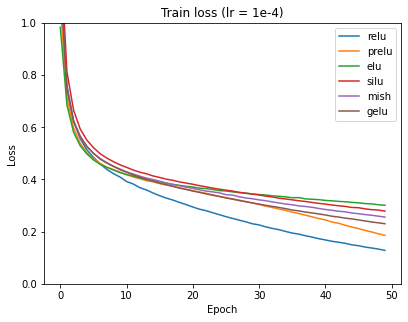

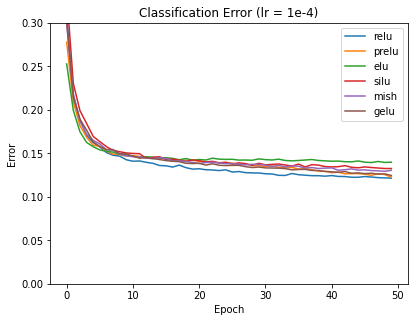

[Classification error (best)]
relu 	 12.150%
prelu 	 12.276%
elu 	 13.940%
silu 	 13.255%
mish 	 12.933%
gelu 	 12.458%


In [181]:
root = '/content/gdrive/MyDrive/DL-HW1/lr1e-4/'

save_history = {}

for nonlinearity_name in nonlinearity_list:

  mean_history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
          'train_acc': [], 'val_acc': [], 'test_acc': []
        }

  for n_exp in range(num_exp):
    with open(os.path.join(root, "twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p"), "rb") as f:
      cur_history = pickle.load(f)
      for k in mean_history.keys():
        mean_history[k].append(cur_history[k])

  for k in mean_history.keys():
    mean_history[k] = np.median(mean_history[k], axis=0)

  save_history[nonlinearity_name] = mean_history

for nonlinearity_name in nonlinearity_list:
  plt.plot(save_history[nonlinearity_name]['train_loss'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.title("Train loss (lr = 1e-4)")
plt.legend()
plt.show()
plt.close()

for nonlinearity_name in nonlinearity_list:
  plt.plot(1-save_history[nonlinearity_name]['test_acc'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0.0, 0.3)
plt.title("Classification Error (lr = 1e-4)")
plt.legend()
plt.show()
plt.close()


print('[Classification error (best)]')
for nonlinearity_name in nonlinearity_list:
  print('%s \t %.3f%%' % (nonlinearity_name, np.min(1-save_history[nonlinearity_name]['test_acc']) * 100))
  accuracy['lr1e-4'][nonlinearity_name] = (1 - np.min(1-save_history[nonlinearity_name]['test_acc'])) * 100

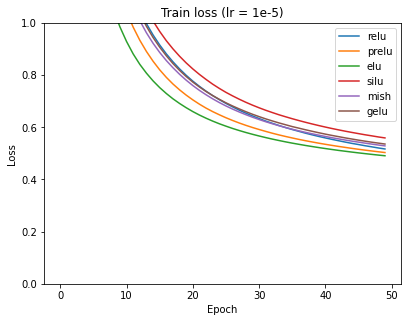

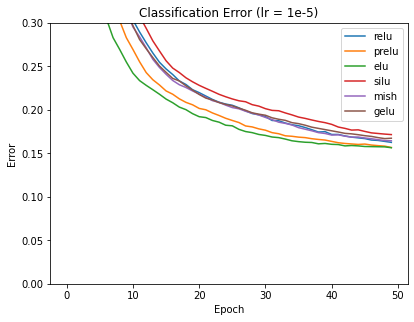

[Classification error (best)]
relu 	 16.261%
prelu 	 15.674%
elu 	 15.646%
silu 	 17.156%
mish 	 16.443%
gelu 	 16.695%


In [182]:
root = '/content/gdrive/MyDrive/DL-HW1/lr1e-5/'

save_history = {}

for nonlinearity_name in nonlinearity_list:

  mean_history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
          'train_acc': [], 'val_acc': [], 'test_acc': []
        }

  for n_exp in range(num_exp):
    with open(os.path.join(root, "twitter_pos_" + nonlinearity_name + '_exp%d' % n_exp + ".p"), "rb") as f:
      cur_history = pickle.load(f)
      for k in mean_history.keys():
        mean_history[k].append(cur_history[k])

  for k in mean_history.keys():
    mean_history[k] = np.median(mean_history[k], axis=0)

  save_history[nonlinearity_name] = mean_history

for nonlinearity_name in nonlinearity_list:
  plt.plot(save_history[nonlinearity_name]['train_loss'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.title("Train loss (lr = 1e-5)")
plt.legend()
plt.show()
plt.close()

for nonlinearity_name in nonlinearity_list:
  plt.plot(1-save_history[nonlinearity_name]['test_acc'], label=nonlinearity_name)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0.0, 0.3)
plt.title("Classification Error (lr = 1e-5)")
plt.legend()
plt.show()
plt.close()


print('[Classification error (best)]')
for nonlinearity_name in nonlinearity_list:
  print('%s \t %.3f%%' % (nonlinearity_name, np.min(1-save_history[nonlinearity_name]['test_acc']) * 100))
  accuracy['lr1e-5'][nonlinearity_name] = (1 - np.min(1-save_history[nonlinearity_name]['test_acc'])) * 100

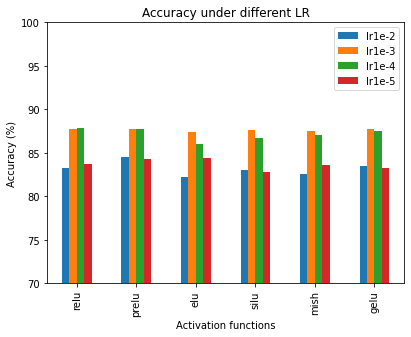

In [183]:
import pandas as pd
pd.DataFrame(accuracy).plot(kind='bar')
plt.xlabel('Activation functions')
plt.ylabel('Accuracy (%)')
plt.ylim(70.0, 100.0)
plt.title("Accuracy under different LR")
plt.show()
plt.close()

In this section, we compare the training and inference time for XX / XX samples, repectively.

Avg. training time per samples for relu ms is 126.2016 μs
Avg. training time per samples for prelu ms is 128.7802 μs
Avg. training time per samples for elu ms is 92.9664 μs
Avg. training time per samples for silu ms is 117.4599 μs
Avg. training time per samples for mish ms is 133.7703 μs
Avg. training time per samples for gelu ms is 214.3286 μs


Avg. inference time per samples for relu ms is 4.5404 μs
Avg. inference time per samples for prelu ms is 7.0469 μs
Avg. inference time per samples for elu ms is 5.1761 μs
Avg. inference time per samples for silu ms is 4.8332 μs
Avg. inference time per samples for mish ms is 10.7620 μs
Avg. inference time per samples for gelu ms is 5.5138 μs


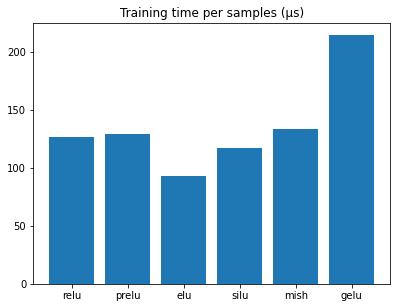

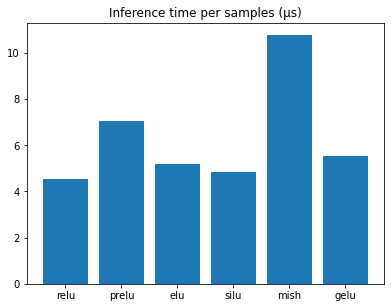

In [184]:
import timeit

learning_rate = 1e-2 # 1e-3 # 1e-4 # 1e-5
testing_epoch = 100
training_times = {}
inference_times = {}

# Training time
for nonlinearity_name in nonlinearity_list:
          
    act_fn = get_act_fn(nonlinearity_name)
    net = Net(act_fn)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Prepare data        
    i = 0
    offset = i * batch_size
    inputs = word_list_to_embedding(data['x_train'][offset:offset + batch_size, :],
                                embeddings, embedding_dimension)
    labels = data['y_train'][offset:offset + batch_size] 

    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
          
    start = timeit.default_timer()

    for epoch in range(testing_epoch):         

        net.train()
        
        # training
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    stop = timeit.default_timer() 

    time = stop - start
    avg_time = time / len(inputs) / testing_epoch
    training_times[nonlinearity_name] = avg_time * 1e6
    print('Avg. training time per samples for %s ms is %.4f μs' % (nonlinearity_name, avg_time * 1e6))


print('\n')


# Inference time
for nonlinearity_name in nonlinearity_list:
          
    act_fn = get_act_fn(nonlinearity_name)
    net = Net(act_fn)

    # Prepare data        
    inputs = word_list_to_embedding(data['x_test'], embeddings, embedding_dimension)
    labels = data['y_test']

    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
          
    start = timeit.default_timer()

    for epoch in range(testing_epoch):
    
        net.eval()

        with torch.no_grad():
          outputs = net(inputs)

    stop = timeit.default_timer()

    time = stop - start
    avg_time = time / len(inputs) / testing_epoch
    inference_times[nonlinearity_name] = avg_time * 1e6
    print('Avg. inference time per samples for %s ms is %.4f μs' % (nonlinearity_name, avg_time * 1e6))



plt.bar(*zip(*training_times.items()))
plt.title("Training time per samples (μs)")
plt.show()
plt.close()

plt.bar(*zip(*inference_times.items()))
plt.title("Inference time per samples (μs)")
plt.show()
plt.close()